In [1]:
import torch
import torchvision
from torch.autograd import Variable 
import torchvision.transforms as transform
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed) # 为CPU设置种子生成随机数，以使结果确定  

# LOAD DATA 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

0it [00:00, ?it/s]

100%|█████████▉| 9904128/9912422 [00:11<00:00, 1661724.24it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 46886.43it/s]
32768it [00:00, 37568.04it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz



 99%|█████████▉| 1630208/1648877 [00:03<00:00, 733296.37it/s]
1654784it [00:03, 427194.61it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 15793.70it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


9920512it [00:30, 1661724.24it/s]                             

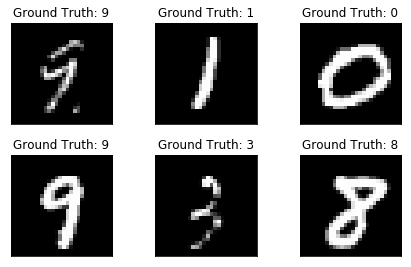

In [4]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
#fig

In [6]:

# Create Model Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [7]:
network = Net()

print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [8]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) #构建mom优化器

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
        output = network(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [12]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3155, Accuracy: 999/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321648
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.277670
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299489
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.304993
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.287651
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.270946
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.229566
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.244529
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.225570
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.168067
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.087137
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.964486
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.031346
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.927215
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.771848
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.710876
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.791293
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.363729
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.427970
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.573212
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.337129
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.285151
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.265245
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.310778
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.451688
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.274011
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.258438
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.431150
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.294422
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.341920
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.344683
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.473857
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.453215
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.552769
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.351684
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.274724
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.431393
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.266575
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.312053


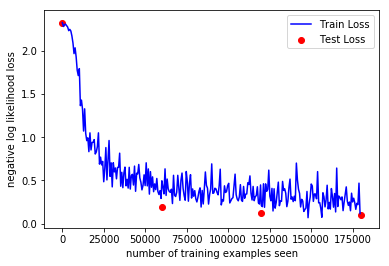

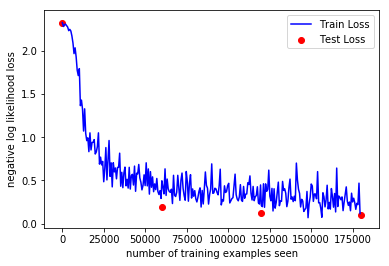

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


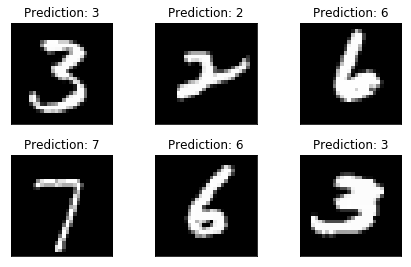

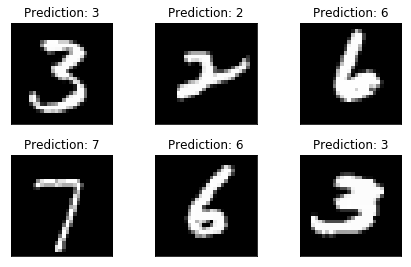

In [14]:
with torch.no_grad():
    output = network(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig